In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from assimilation import OI, M3DVar, ExtendedKF, EnKF

plt.style.use('seaborn')

In [2]:
def lorenz96_fdm(x0, ts, F=8):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

### Create nature run

In [3]:
ndim = 40

F = 8
spn_time = 100
dt = 0.01
spn_ts = np.arange(0, spn_time, dt)

# spin up and get the initial condition for nature run
x0 = 0.1 * np.random.randn(ndim)
x_forecast = lorenz96_fdm(x0, spn_ts, F)
X_nature_ini = x_forecast[:,[-1]]

# create nature run
time = 16
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(X_nature_ini, ts, F)
X_nature.shape

(40, 1600)

### Create initial condition

In [4]:
# spin up and use the last one as initial condition for experiments
spn_time = 100
spn_ts = np.arange(0, spn_time, dt)
x0 = 0.1 * np.random.randn(ndim)
x_forecast = lorenz96_fdm(x0, spn_ts, F)
X_ini = x_forecast[:,[-1]]
X_ini.shape

(40, 1)

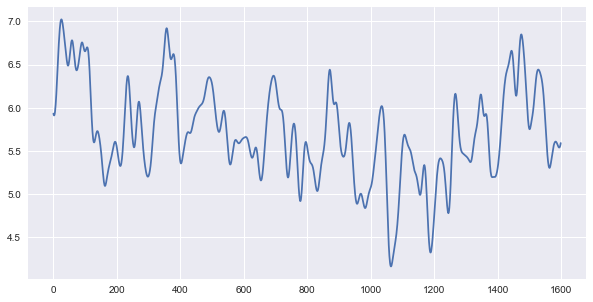

In [5]:
# noDA
time = 16
ts = np.arange(0, time, dt)
X_forecast = lorenz96_fdm(X_ini, ts, F)
rmse = np.sqrt(np.mean((X_forecast-X_nature)**2, axis=0))

plt.figure(figsize=(10, 5))
plt.plot(rmse);

### Simulated observation

In [9]:
def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err

In [10]:
obs_mean = [0 for _ in range(ndim)]
obs_var = [2 for _ in range(ndim)]

# create observation error
X_obserr = np.zeros_like(X_nature)
obs_intv = 8
size = X_obserr.shape[1]
for i, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
    X_obserr[i,:] = gen_random_obserr(obsm, obsv, size, obs_intv)
    
# create observation
X_obs = X_nature + X_obserr
X_obs = X_obs[:,::obs_intv]
X_obs.shape

(40, 200)

In [11]:
R = np.eye(ndim)
np.fill_diagonal(R, obs_var)
R

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

### NMC

In [12]:
### old NMC and it is trash
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2, dt)
        xs = model(x0, ts)
        result[n,0,:] = xs[:,int(t1/dt)]
        result[n,1,:] = xs[:,-1]

    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

## new NMC
def nmc(model, ref, dt, alpha, t1):
    ndim, length = ref.shape
    x0 = ref[:,0]
    t1_nstep = int(t1 / dt)
    num = length // t1_nstep - 1
    
    result = np.zeros((num, ndim, 2*t1_nstep))
    for i in range(num):
        idx = i * t1_nstep
        scale = ref[:,idx].mean()
        x0 = ref[:,idx] + np.random.randn(ndim) * scale
        ts = np.arange(0, 2*t1_nstep*dt, dt)  # shape=(2*t1_step,)
        x_forecast = model(x0, ts)
        result[i,:] = x_forecast
    
    xfcst_short = []
    xfcst_long = []
    for xfcst in result:
        # x_f.shape = (ndim, 2*t1_nstep)
        xfcst_short.append(xfcst[:,t1_nstep-1])
        xfcst_long.append(xfcst[:,2*t1_nstep-1])
    
    Pb = np.zeros((ndim, ndim))
    for xshort, xlong in zip(xfcst_short[1:], xfcst_long[:-1]):
        # xshort.shape = xlong.shape = (ndim,)
        # convert to column vector
        xshort = xshort[:,np.newaxis]
        xlong = xlong[:,np.newaxis]
        Pb = Pb + (xlong-xshort) @ (xlong-xshort).T
    return alpha * Pb / (num-1)

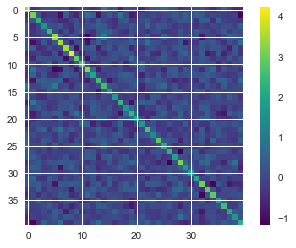

In [13]:
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
#Pb = nmc(lorenz96_fdm, X_nature, dt, alpha=50, t1=2, t2=4, num=10)
Pb = nmc(lorenz96_fdm, X_nature, dt, alpha=1, t1=0.2)
Pb *= 0.1

plt.imshow(Pb, cmap='viridis', interpolation='nearest')
plt.colorbar();

In [26]:
np.save('lorenz96_Pb', Pb)

### OI

In [14]:
oi = OI(lorenz96_fdm, dt)
oi.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(ndim)
}
oi.set_params(**params)
oi.cycle()

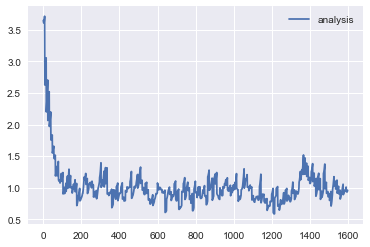

In [15]:
rmse = np.sqrt(np.mean((oi.analysis-X_nature)**2, axis=0))
plt.plot(rmse, label='analysis')
plt.legend()

### 3DVar

In [16]:
tdv = M3DVar(lorenz96_fdm, dt)
tdv.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
}
tdv.set_params(**params)
tdv.cycle()

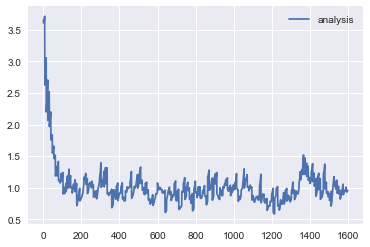

In [17]:
rmse = np.sqrt(np.mean((tdv.analysis-X_nature)**2, axis=0))
plt.plot(rmse, label='analysis')
plt.legend()

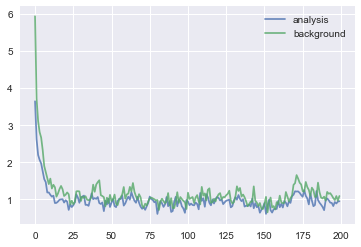

In [18]:
rmse = np.sqrt(np.mean((tdv.analysis-X_nature)**2, axis=0))
plt.plot(rmse[::obs_intv], label='analysis', alpha=0.8)
rmse2 = np.sqrt(np.mean((tdv.background-X_nature)**2, axis=0))
plt.plot(rmse2[::obs_intv], label='background', alpha=0.8)
plt.legend()

### EKF

In [19]:
def M(x, dt, F):
    """tangent linear model for lorenz96_fdm"""
    ndim = x.size
    m = np.zeros((ndim, ndim))
    np.fill_diagonal(m, 1 + dt * (F-1))
    
    up1 = np.roll(np.delete(x, 38), 1) * dt
    m += np.diag(up1, k=1)
    m[-1,0] = x[38] * dt
    
    low1 = (np.roll(np.delete(x, 1), -1) 
            - np.roll(np.delete(x, 38), 1)) * dt
    m += np.diag(low1, k=-1)
    m[0,-1] = (x[1] - x[38]) * dt
    
    low2 = -np.delete(x, [0, 39]) * dt
    m += np.diag(low2, k=-2)
    m[0,-2] = -x[-1] * dt
    m[1,-1] = -x[0] * dt
    
    return m

In [20]:
### check M

#plt.figure(figsize=(15, 15))
#sns.heatmap(M(x, 1, 8), annot=True, fmt=".0f")

In [21]:
ekf = ExtendedKF(lorenz96_fdm, dt)
ekf.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(ndim),
    'M': lambda x: M(x, dt, F),
    'alpha': 0.3,
    'inflat': 1.5
}
ekf.set_params(**params)
ekf.cycle()

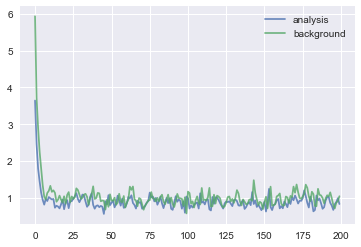

In [22]:
rmse = np.sqrt(np.mean((ekf.analysis-X_nature)**2, axis=0))
plt.plot(rmse[::obs_intv], label='analysis', alpha=0.8)
rmse2 = np.sqrt(np.mean((ekf.background-X_nature)**2, axis=0))
plt.plot(rmse2[::obs_intv], label='background', alpha=0.8)
plt.legend()

### EnKF

In [23]:
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

enkf = EnKF(lorenz96_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle()

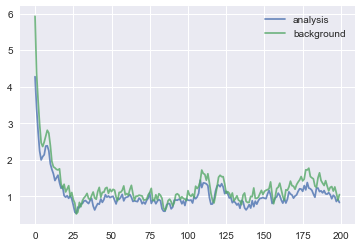

In [24]:
ensmean_a = enkf.analysis.mean(axis=0)
ensmean_b = enkf.background.mean(axis=0)

rmse = np.sqrt(np.mean((ensmean_a-X_nature)**2, axis=0))
plt.plot(rmse[::obs_intv], label='analysis', alpha=0.8)
rmse2 = np.sqrt(np.mean((ensmean_b-X_nature)**2, axis=0))
plt.plot(rmse2[::obs_intv], label='background', alpha=0.8)
plt.legend()